In [22]:
import numpy as np
import matplotlib.pyplot as plt

def plot_policy(values, title):
    policy = np.zeros_like(values, dtype='<U2')
    n, m = values.shape
    for i in range(n):
        for j in range(m):
            best_action = None
            best_value = -np.inf
            directions = {'U': (-1, 0), 'D': (1, 0), 'L': (0, -1), 'R': (0, 1)}
            for d, (di, dj) in directions.items():
                ni, nj = i + di, j + dj
                if 0 <= ni < n and 0 <= nj < m:
                    if values[ni, nj] > best_value:
                        best_value = values[ni, nj]
                        best_action = d
            if best_action:
                policy[i, j] = best_action.replace('U', '↑').replace('D', '↓').replace('L', '←').replace('R', '→')
    plt.imshow(np.zeros_like(values), cmap='Greys', alpha=0.3)
    for i in range(n):
        for j in range(m):
            plt.text(j, i, policy[i, j], ha='center', va='center', color='black')
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
    plt.show()

# 2. Iterative Policy Evaluation


[[ 2.155382    0.          2.40682657  0.          0.39624276]
 [ 0.55399724  0.          0.35875701  0.         -0.7030474 ]
 [-0.37676859 -0.24076801 -0.36996053 -0.84595829 -1.07445687]
 [-0.99656018 -0.79336553 -0.82977873 -1.06489948 -1.37427183]
 [-1.50306486 -1.2734109  -1.26561098 -1.4338098  -1.74649582]]


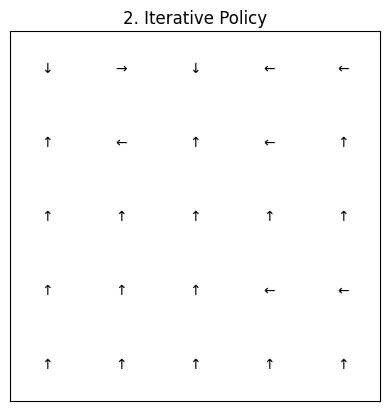

In [23]:
import numpy as np

def initialize_grid():
    grid = np.zeros((5, 5))
    rewards = {(0, 1): 5, (0, 3): 2.5, (1, 1): 0.5, (1, 3): -1}
    return grid, rewards

def is_terminal_state(x, y):
    if (x, y) in [(0, 1), (0, 3), (1, 1), (1, 3)]:  # terminal states with unique rewards and transitions
        return True
    return False

def get_next_state_reward(x, y):
    if (x, y) == (0, 1):
        return (1, 1), 5  # Teleports to the red square
    elif (x, y) == (0, 3):
        if np.random.rand() < 0.5:
            return (1, 1), 2.5  # 50% chance to teleport to red
        else:
            return (1, 3), 2.5  # 50% chance to teleport to yellow
    elif (x, y) == (1, 1):
        return (1, 1), 0.5  # Stays in place
    elif (x, y) == (1, 3):
        return (1, 3), -1  # Stays in place
    return (x, y), 0  # Default reward for non-special states

def iterate_value(grid):
    gamma = 0.95
    new_grid = np.copy(grid)
    for x in range(5):
        for y in range(5):
            if not is_terminal_state(x, y):
                values = []
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # possible moves
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < 5 and 0 <= ny < 5:
                        next_state, reward = get_next_state_reward(nx, ny)
                        values.append(reward + gamma * grid[next_state])
                    else:
                        values.append(-0.5 + gamma * grid[x, y])  # penalty for off-grid move
                new_grid[x, y] = np.mean(values)
    return new_grid

def main():
    grid, rewards = initialize_grid()
    for _ in range(100):  # Arbitrary number of iterations for convergence
        grid = iterate_value(grid)
    print()
    print(grid)
    plot_policy(grid,"2. Iterative Policy")

if __name__ == "__main__":
    main()


# 1. Bellman Equations

Solution to the system of Bellman equations:
[[ 10.58316979  14.5          3.21388655  -2.25        -6.11071899]
 [  7.78035746  10.          -2.10088459 -20.         -10.61467155]
 [  3.98638007   3.01745485  -2.05971641  -7.97494924  -7.40929644]
 [  1.79075634   0.7784094   -1.61411116  -4.10972078  -4.80815745]
 [  0.89023055   0.08341323  -1.40522974  -2.90686966  -3.66463788]]


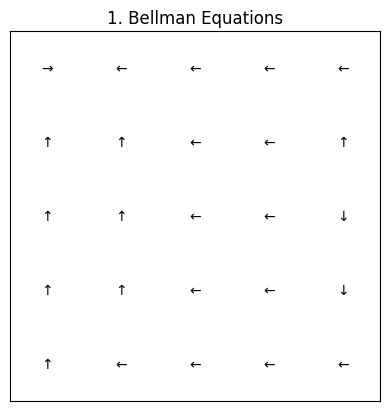

In [24]:
import numpy as np

def setup_system():
    # Define the dimensions of the grid
    n = 5
    V = np.zeros(n * n)  # Initialize the values of all states to zero
    R = np.zeros(n * n)  # Reward for each state
    P = np.zeros((n * n, n * n))  # Transition probabilities

    # Setting up rewards and transition probabilities
    # Map (x, y) to a linear index idx = x * n + y for easier matrix manipulation
    def idx(x, y):
        return x * n + y

    # Define rewards and transitions
    R[idx(0, 1)] = 5
    R[idx(0, 3)] = 2.5
    R[idx(1, 1)] = 0.5
    R[idx(1, 3)] = -1

    # Transitions
    # Assuming each non-terminal action leads uniformly to its neighbors or itself if off-grid
    for x in range(n):
        for y in range(n):
            current_idx = idx(x, y)
            neighbors = []
            if x > 0: neighbors.append(idx(x-1, y))
            if x < n-1: neighbors.append(idx(x+1, y))
            if y > 0: neighbors.append(idx(x, y-1))
            if y < n-1: neighbors.append(idx(x, y+1))
            
            if not neighbors:  # If no valid moves, return to itself (corner case for isolated states, not expected here)
                neighbors.append(current_idx)
            
            for neighbor in neighbors:
                P[current_idx, neighbor] += 1.0 / len(neighbors)

    # Adjust for special transitions
    P[idx(0, 1), :] = 0
    P[idx(0, 1), idx(1, 1)] = 1  # Blue to Red

    P[idx(0, 3), :] = 0
    P[idx(0, 3), idx(1, 1)] = 0.5  # Green to Red
    P[idx(0, 3), idx(1, 3)] = 0.5  # Green to Yellow

    # Red and Yellow are terminal in behavior but not absorbing states
    P[idx(1, 1), :] = 0
    P[idx(1, 1), idx(1, 1)] = 1  # Red stays

    P[idx(1, 3), :] = 0
    P[idx(1, 3), idx(1, 3)] = 1  # Yellow stays

    return V, R, P

def solve_bellman(V, R, P, gamma=0.95):
    # The Bellman equation for v_pi is: v = R + gamma * P * v
    # Rearrange to (I - gamma * P) * v = R
    n = len(V)
    A = np.eye(n) - gamma * P
    b = R
    V = np.linalg.solve(A, b)
    return V.reshape((5, 5))

def main():
    V, R, P = setup_system()
    solution = solve_bellman(V, R, P)
    print("Solution to the system of Bellman equations:")
    print(solution)
    plot_policy(solution,"1. Bellman Equations")

if __name__ == "__main__":
    main()


# 3. Value Iteration

Optimal values for each state after value iteration:
[[5.         0.         5.         0.         3.67545945]
 [4.75       0.         4.75       0.         3.86890469]
 [4.5125     4.286875   4.5125     4.286875   4.07253125]
 [4.286875   4.07253125 4.286875   4.07253125 3.86890469]
 [4.07253125 3.86890469 4.07253125 3.86890469 3.67545945]]


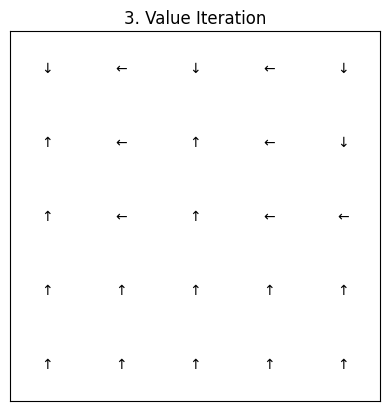

In [25]:
import numpy as np

def setup_gridworld():
    n = 5  # Grid size
    V = np.zeros((n, n))  # Value for each state
    rewards = np.zeros((n, n))  # Reward for each state
    is_terminal = np.zeros((n, n), dtype=bool)  # Terminal state indicator

    # Define rewards and terminal states
    rewards[0, 1] = 5  # Blue
    rewards[0, 3] = 2.5  # Green
    rewards[1, 1] = 0.5  # Red
    rewards[1, 3] = -1  # Yellow

    # Define terminal states
    is_terminal[0, 1] = True  # Blue
    is_terminal[0, 3] = True  # Green
    is_terminal[1, 1] = True  # Red
    is_terminal[1, 3] = True  # Yellow

    return V, rewards, is_terminal

def value_iteration(V, rewards, is_terminal, gamma=0.95, threshold=0.001):
    n = len(V)

    while True:
        delta = 0
        new_V = np.copy(V)
        for x in range(n):
            for y in range(n):
                if not is_terminal[x, y]:
                    v = V[x, y]
                    # Calculate value from all possible actions
                    values = []
                    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < n and 0 <= ny < n:
                            values.append(rewards[nx, ny] + gamma * V[nx, ny])
                        else:
                            values.append(-0.5 + gamma * V[x, y])  # Off-grid penalty
                    new_V[x, y] = max(values)
                    delta = max(delta, abs(v - new_V[x, y]))
        V = new_V
        if delta < threshold:
            break

    return V

def main():
    V, rewards, is_terminal = setup_gridworld()
    optimal_values = value_iteration(V, rewards, is_terminal)
    print("Optimal values for each state after value iteration:")
    print(optimal_values)
    plot_policy(optimal_values,"3. Value Iteration")

if __name__ == "__main__":
    main()